# Formalia:

Please read the [assignment overview page](https://github.com/SocialComplexityLab/socialgraphs2021/wiki/Assignments) carefully before proceeding. This page contains information about formatting (including formats etc.), group sizes, and many other aspects of handing in the assignment. 

_If you fail to follow these simple instructions, it will negatively impact your grade!_

**Due date and time**: The assignment is due on Tuesday November the 2nd, 2021 at 23:59. Hand in your IPython notebook file (with extension `.ipynb`) via http://peergrade.io/

### Overview

This year's Assignment 2 is all about analyzing the network of The Legend of Zelda: Breath of the Wild.

Note that this time I'm doing the exercises slightly differently in order to clean things up a bit. The issue is that the weekly lectures/exercises include quite a few instructions and intermediate results that are not quite something you guys can meaningfully answer. 

Therefore, in the assignment below, I have tried to reformulate the questions from the weekly exercises into something that is (hopefully) easier to answer. *Then I also note which lectures each question comes from*; that way, you can easily go back and find additional tips & tricks on how to solve things 😇


----

# Part 0: Building the network 

To create our network, we downloaded the Zelda Wiki pages for all characters in BotW (during Week 4) and linked them via the hyperlinks connecting pages to each other. To achieve this goal we have used regular expressions!

> * Explain the strategy you have used to extract the hyperlinks from the Wiki-pages, assuming that you have already collected the pages with the Zelda API.
> * Show the regular expression(s) you have built and explain in details how it works.

In [70]:
import urllib
import re
import pandas as pd
import io
import requests
from pathlib import Path
import numpy as np
import networkx as nx
from zipfile import ZipFile
from fa2 import ForceAtlas2

In [71]:
#Read the ZeldaBotW_nodes_w_attributes_enriched.CSV file into a Pandas df
url= "https://raw.githubusercontent.com/SocialComplexityLab/socialgraphs2021/main/files/ZeldaBotW_nodes_w_attributes_enriched.csv"
df = pd.read_csv(url)

### The .txt files extracted using the Zelda API for each character are uploaded from a local folder "characters/" (zipped)

In [119]:
#Extract the pages with the characters' description from the Zelda API from local folder

# Extract all the files
with ZipFile("characters.zip", 'r') as zipFile:
    zipFile.extractall()
    
path = "characters/"

In [121]:
links = []

##For each character in the csv, extract the links to the nodes in the descripton file
path = "characters/"

for node in df["Name"]:
    with open(path+node+".txt","r") as f:
        node_description = f.read()
    #hypyerlink regex that link to another node of the network (e.g. another character). 
    pattern1 = r'\[\[(.*?)(?:\|.*?|\#Breath of the Wild)?\]\]'
    pattern2 = r'\{\{(?:Plural|Term)\|BotW\|(.*?)(?:\|display.*?)?(\|link)?(?:\|display.*?)?\}\}'

    # find patterns of two types and filter non-links
    links_pattern1 = list(re.findall(pattern1, node_description))
    links_pattern2 = [l[0] for l in re.findall(pattern2, node_description) if "|link" in l]

    links_total = [l for l in set(links_pattern1+links_pattern2) if l in df.Name.values]

    links.append(links_total)

In [227]:
import networkx as nx
G = nx.DiGraph()
nodes_with_attributes = [(df.Name[i],{'Role':df.Role[i],'Race':df.Race[i],'Gender':df.Gender[i]}) for i in df.index]
G.add_nodes_from(nodes_with_attributes)

list_dict = {df.Name.values[i]: x for i,x in enumerate(links) for y in x if (y in df.Name.values)}
G.add_edges_from([(x,i) for x in list_dict for i in list_dict[x]])
print(f'num nodes: {G.number_of_nodes()}')
print(f'num edges: {G.number_of_edges()}')

num nodes: 656
num edges: 1640


In [144]:
# Remove isolated nodes from the network
# Extract the largest component LC
LC = max(nx.weakly_connected_components(G),key=len)
# # Save only the largest component as G
G = nx.DiGraph(G.subgraph(LC))


print(f'num nodes after removing isolated groups: {G.number_of_nodes()}')
print(f'num edges after removing isolated groups: {G.number_of_edges()}')

num nodes after removing isolated groups: 531
num edges after removing isolated groups: 1629


## Run the code before you proceed with your part! 

### Path to txt files: "characters/"
### Dataframe with characters' name from the prof: https://raw.githubusercontent.com/SocialComplexityLab/socialgraphs2021/main/files/ZeldaBotW_nodes_w_attributes_enriched.csv
### Name of the network: G



# Part 1: Network visualization and basic stats

Visualize the network (from lecture 5) and calculate stats (from lecture 4 and 5). For this exercise, we assume that you've already generated the BotW network and extracted the giant connected component. Use the GCC to report the results.

_Exercise 1a_: Stats (see lecture 4 and 5 for more hints)

> * What is the number of nodes in the network? 
> * What is the number of links?

In [155]:
#nodes
print("Nodes:"§, len(list(G.nodes())))
print("Links: ", G.number_of_edges())

Nodes: 462
Links:  1560


> * Who is the top connected character in BotW? (Report results for the in-degrees and out-degrees). Comment on your findings. Is this what you would have expected?

In [159]:
in_deg = [v for k, v in dict(G.in_degree).items()]
out_deg =  [v for k, v in dict(G.out_degree).items()]
degrees = [v for k, v in dict(G.degree).items()]


# max_degree = np.max(in_deg)
# min_degree = np.min(in_deg)
# vector = np.arange(min_degree,max_degree)
# hist, bin_edges = np.histogram(in_deg, bins=vector)
# bin_means = [0.5 * (bin_edges[i] + bin_edges[i+1]) for i in range(len(bin_edges)-1)]
#plt.bar(bin_means, hist, width=bin_edges[1] - bin_edges[0])


In [200]:
top_character_in = sorted([(node, degree) for node, degree in G.in_degree], key=lambda t: t[1])[-5:]
top_character_out = sorted([(node, degree) for node, degree in G.out_degree], key=lambda t: t[1])[-5:]
print(top_character_in[4])
print(top_character_out[4])

('Link', 354)
('Traysi', 14)


> * Who are the top 5 most connected allies (again in terms of in/out-degree)? 
> * Who are the top 5 most connected enemies -- bosses included -- (again in terms of in/out-degree)?

In [193]:
allies = [(node, degree) for node, degree in G.in_degree if G.nodes[node]['Role']=='Ally' ]
ennemies = [(node, degree) for node, degree in G.in_degree if (G.nodes[node]['Role']=='Ennemy' or  G.nodes[node]['Role']=='Boss')]

In [194]:
top_ally_in = sorted([(node, degree) for node, degree in allies], key=lambda t: t[1])[-5:]
top_ally_out = sorted([(node, degree) for node, degree in allies], key=lambda t: t[1])[-5:]

In [196]:
top_ally_in

[('Mipha', 17),
 ('Riju', 23),
 ('Princess Zelda', 24),
 ('Hylia', 67),
 ('Link', 354)]

In [198]:
top_ally_out

[('Mipha', 17),
 ('Riju', 23),
 ('Princess Zelda', 24),
 ('Hylia', 67),
 ('Link', 354)]

In [199]:
top_ennemy_in = sorted([(node, degree) for node, degree in ennemies], key=lambda t: t[1])[-5:]
top_ennemy_out = sorted([(node, degree) for node, degree in ennemies], key=lambda t: t[1])[-5:]

> * Plot the in- and out-degree distributions. 
>   * What do you observe? 
>   * Can you explain why the in-degree distribution is different from the out-degree distribution?
> * Find the exponent of the degree distribution (by using the `powerlaw` package) for the in- and out-degree distribution. What does it say about our network?

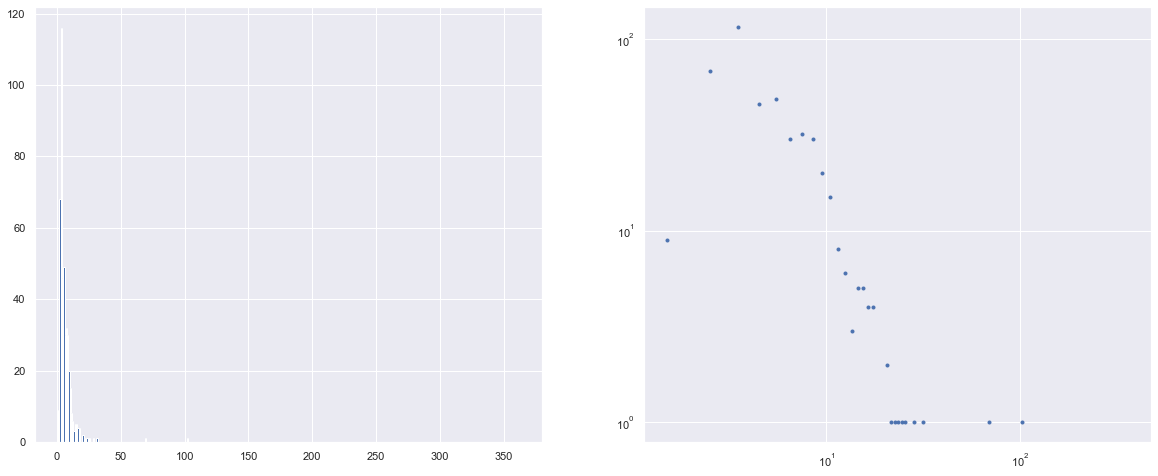

In [160]:
import seaborn as sns
sns.set()
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(20,8))


max_degree = np.max(degrees)
min_degree = np.min(degrees)
vector = np.arange(min_degree,max_degree)
hist_pois, bin_edges = np.histogram(degrees,bins=vector)
hist, bin_edges = np.histogram(degrees, bins=vector)
bin_means = [0.5 * (bin_edges[i] + bin_edges[i+1]) for i in range(len(bin_edges)-1)]
ax1.bar(bin_means, hist, width=bin_edges[1] - bin_edges[0])
plt.loglog(bin_means, hist, marker='.', linestyle='None')

> * Compare the degree distribution of the undirected graph to a *random network* with the same number of nodes and probability of connection *p*. Comment your results.

In [208]:
def plot_graph(G):
    fig, ax = plt.subplots(1, figsize=(10,8))
    degrees = [v for k, v in dict(G.degree).items()]
    max_degree = np.max(degrees)
    min_degree = np.min(degrees)
    vector = np.arange(min_degree,max_degree)
    hist_pois, bin_edges = np.histogram(degrees,bins=vector)
    hist, bin_edges = np.histogram(degrees, bins=vector)
    bin_means = [0.5 * (bin_edges[i] + bin_edges[i+1]) for i in range(len(bin_edges)-1)]
    plt.bar(bin_means, hist, width=bin_edges[1] - bin_edges[0])
    plt.show()

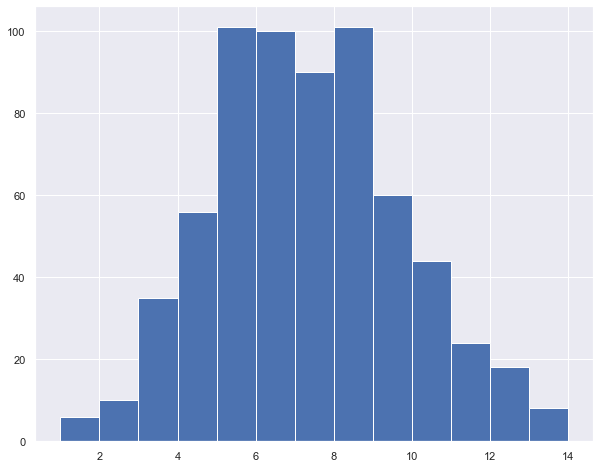

In [209]:
#random network with the same probability??
nodes = len(df)
degrees = [v for k, v in dict(G.degree).items()]
p = np.mean(degrees)/(nodes-1)
G_RN = nx.erdos_renyi_graph(n=nodes, p=p)
plot_graph(G_RN)


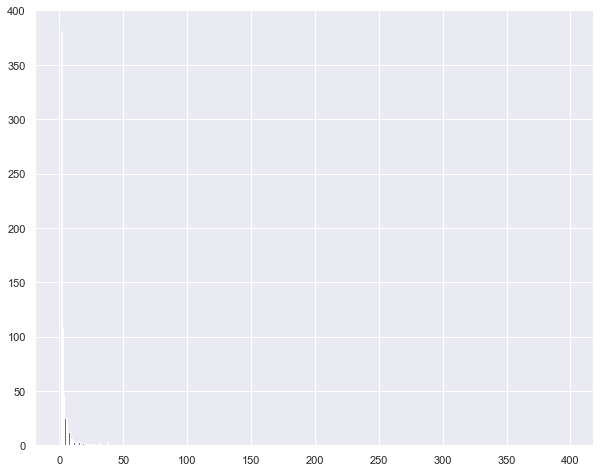

In [213]:
#scale-free network
G_SF = nx.scale_free_graph(nodes)
plot_graph(G_SF)

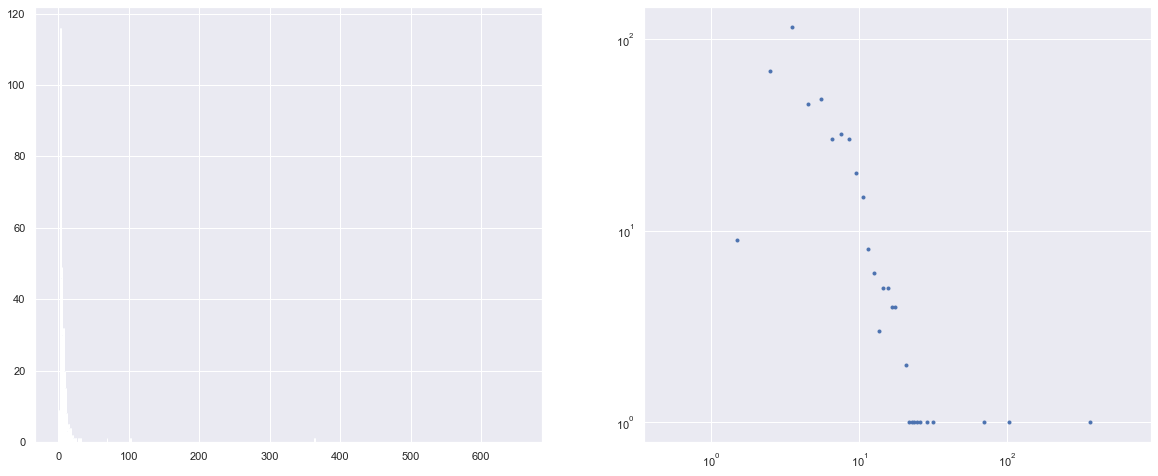

In [218]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(20,8))


max_degree = np.max(G_SF.degree)
min_degree = np.min(G_SF.degree)
vector = np.arange(min_degree,max_degree)
hist_pois, bin_edges = np.histogram(G_SF.degree,bins=vector)
hist, bin_edges = np.histogram(degrees, bins=vector)
bin_means = [0.5 * (bin_edges[i] + bin_edges[i+1]) for i in range(len(bin_edges)-1)]
ax1.bar(bin_means, hist, width=bin_edges[1] - bin_edges[0])
plt.loglog(bin_means, hist, marker='.', linestyle='None')

_Exercise 1b_: Visualization (see lecture 5 for more hints)

> * Create a nice visualization of the total (undirected) network:
>   * Color nodes according to the role;
>   * Scale node-size according to degree;
>   * Get node positions based on the Force Atlas 2 algorithm;
>   * Whatever else you feel like that would make the visualization nicer.
> * Describe the structure you observe. Can you identify nodes with a privileged position in the network? Do you observe chains of connected nodes? Do you see any interesting group of nodes (can you guess who's involved)?

In [76]:
def role_to_color(role):
    if role =='Ally':
        return "green"
    elif role =='Enemy':
        return "blue"
    elif role =='Boss':
        return "red"
   

In [77]:
def node_degree_to_size(degree):
    return degree

In [78]:
def node_degree_to_label(degree):
    return degree > 22

In [231]:
# Remove isolated nodes from the network
G.remove_nodes_from(list(nx.isolates(G)))
x=[node for node, degree in G.degree if degree == 0]
G.remove_nodes_from(x)
x=[node for node, degree in G.degree if degree < 1]
G.remove_nodes_from(x)
LC = max(nx.weakly_connected_components(G),key=len)
# # Save only the largest component as G
GG = nx.DiGraph(G.subgraph(LC))
del G
print(f'num nodes after removing isolates: {GG.number_of_nodes()}')
print(f'num edges after removing isolates: {GG.number_of_edges()}')
# Extract the largest component LC
#LC = max(nx.weakly_connected_components(G),key=len)
#print(len(LC))

num nodes after removing isolates: 531
num edges after removing isolates: 1629


In [232]:
#Node color should depend on the role attribute
G_undirected = GG.to_undirected()


In [233]:
role = nx.get_node_attributes(G_undirected, 'Role')
role_color = [role_to_color(r) for r in role.values()]
#node-size depends on the node degree
node_size = [node_degree_to_size(d) for k, d in dict(G_undirected.degree).items()]
#node label
node_label = {k:k for k, d in dict(G_undirected.degree).items() if node_degree_to_label(d)}

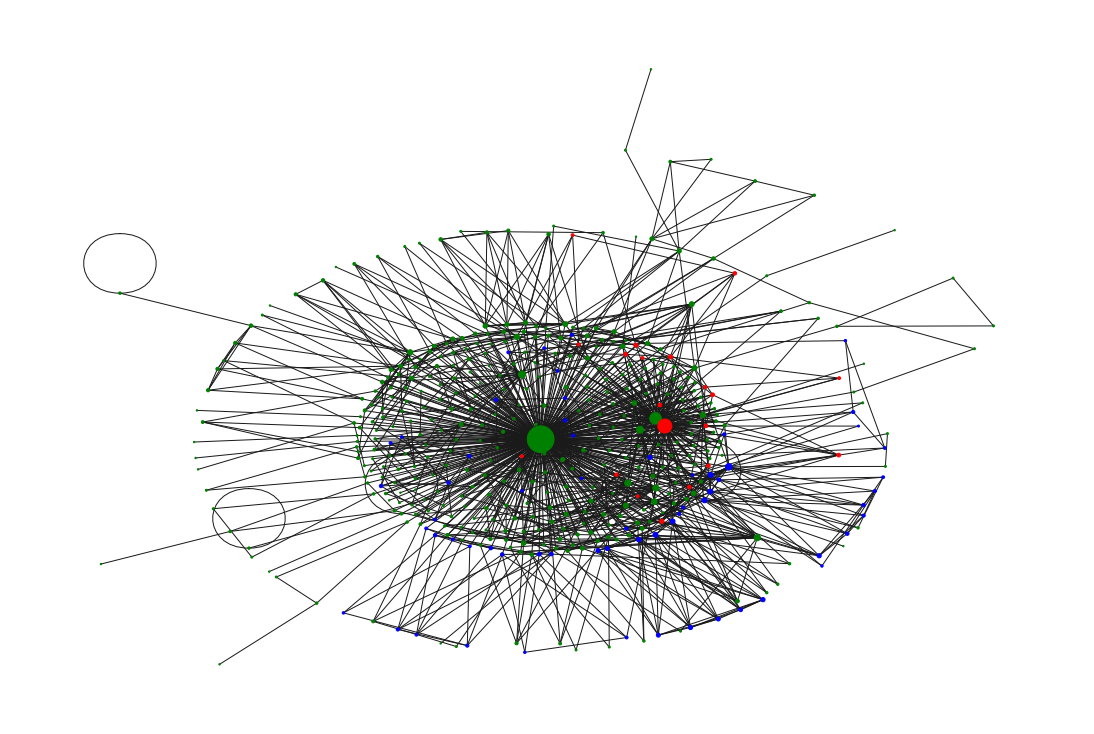

In [223]:
plt.rcParams['figure.figsize'] = [15, 10]

#nx.draw_kamada_kawai(G_undirected, node_color=node_colors, node_size=node_size, arrowstyle=ArrowStyle.Curve())
nx.draw_kamada_kawai(G_undirected, nodelist=[v for v in dict(G_undirected.degree).keys()], 
                     node_size=[v*2 for v in dict(G_undirected.degree).values()], node_color=role_color)

In [224]:
def plot_with_fa(graph, _node_colors, _node_size, _node_label):
    forceatlas2 = ForceAtlas2(
                            # Behavior alternatives
                            outboundAttractionDistribution=True,  # Dissuade hubs
                            edgeWeightInfluence=1.0,

                            # Performance
                            jitterTolerance=7,  # Tolerance
                            barnesHutOptimize=True,
                            barnesHutTheta=1.6,

                            # Tuning
                            scalingRatio=1.0,
                            strongGravityMode=False,
                            gravity=15.0,

                            # Log
                            verbose=True)

    positions = forceatlas2.forceatlas2_networkx_layout(graph, pos=None, iterations=2000)
    nx.draw_networkx_nodes(graph, positions, alpha=1, node_color=_node_colors, node_size=_node_size)
    nx.draw_networkx_edges(graph, positions, edge_color="green", alpha=0.15)
    nx.draw_networkx_labels(graph,positions, _node_label ,font_size=10, font_color='black')

    plt.axis('off')
    plt.show()


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:07<00:00, 276.83it/s]


BarnesHut Approximation  took  2.47  seconds
Repulsion forces  took  3.77  seconds
Gravitational forces  took  0.11  seconds
Attraction forces  took  0.05  seconds
AdjustSpeedAndApplyForces step  took  0.33  seconds


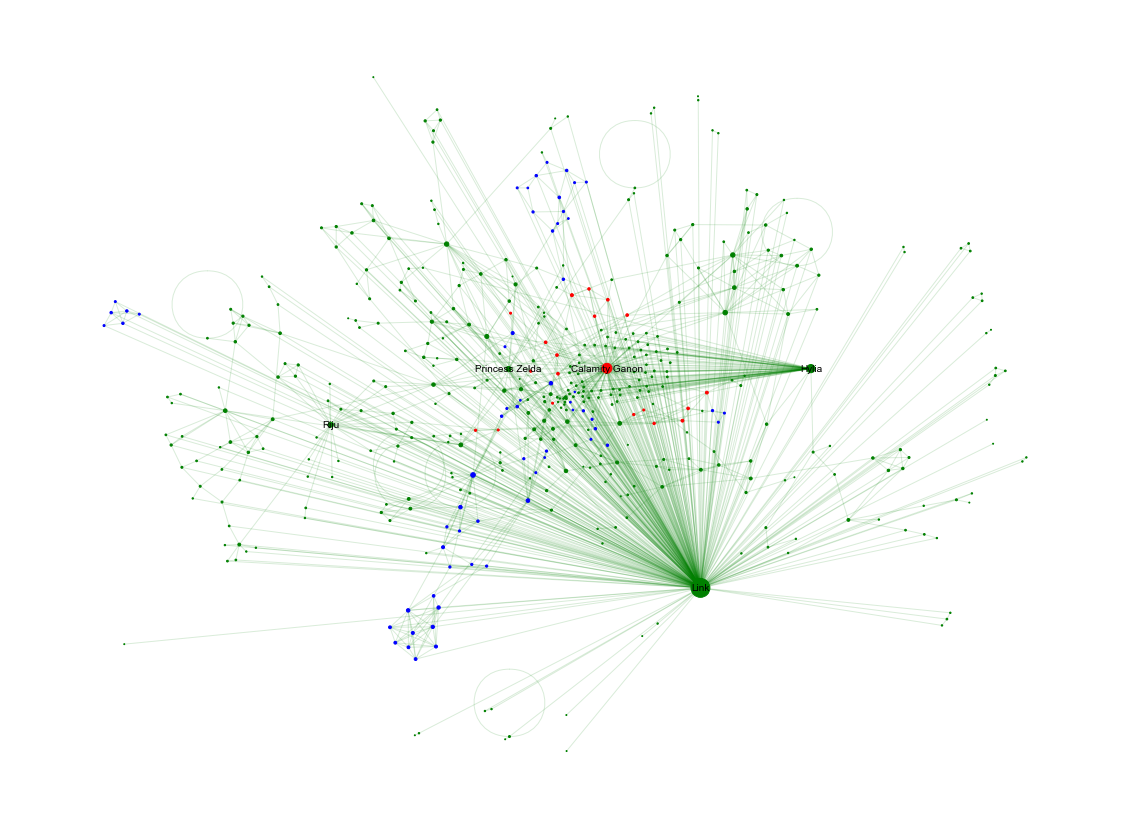

In [225]:
plt.rcParams['figure.figsize'] = [20, 15]
plot_with_fa(G_undirected, role_color, node_size, node_label)

# Part 2: Word-clouds

Create your own version of the word-clouds (from lecture 7). For this exercise we assume you know how to download and clean text from the ZeldaWiki pages.

Here's what you need to do:
> * Create a word-cloud for each race of the [five champions of Hyrule](https://zelda.fandom.com/wiki/Champions) (i.e. Hylian, Zora, Goron, Gerudo, and Rito) according to either TC-IDF. Feel free to make it as fancy as you like. Explain your process and comment on your results.

# Part 3: Communities and TF-IDF

Find communities and compute their associated TF-IDF (from lecture 7 and 8).

Here's what you need to do:
> * Explain the Louvain algorithm and how it finds communities in a newtork.
> * Explain how you chose to identify the communities: Which algorithm did you use? (if you did not use the Louvain method, explain how the method you have used works) 
> * Comment your results:
>   * How many communities did you find in total?
>   * Compute the value of modularity with the partition created by the algorithm.
>   * Plot the distribution of community sizes.
> * For the 5 largest communities, create TF-IDF based rankings of words in each community. 
>   * There are many ways to calculate TF-IDF, explain how you've done it and motivate your choices.
>   * List the 5 top words for each community according to TF.
>   * List the 5 top words for each community accourding to TF-IDF. Are these words more descriptive of the community than just the TF? Justify your answer.

In [11]:
#Files: pages of the characters

# Part 4: Sentiment of communities

Analyze the sentiment of the communities (lecture 8). Here, we assume that you've successfully identified communities.  More tips & tricks can be found, if you take a look at Lecture 8's exercises.

A couple of additional instructions you will need below:
* We name each community by its three most connected characters.
* Average the average sentiment of the nodes in each community to find a community level sentiment.

Here's what you need to do (repeat these steps and report your results for **both LabMT and VADER**):
> * Calculate and store sentiment for every character
> * Create a histogram of all character's associated sentiments.
> * What are the 10 characters with happiest and saddest pages?

Now, compute the sentiment of communities: 
> * What are the three happiest communities according to the LabMT wordlist approach? What about VADER?
> * What are the three saddest communities according to the LabMT wordlist approach? What about VADER?
> * Create a bar plot showing the average sentiment of each community and add error-bars using the standard deviation for both methods. 
> * Explain the difference between the two methods and compare the results you have obtained above.
> * What is the advantage of using a rule-based method over the dictionary-based approach? 